In [1]:
# Importing the necessay libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()
# rake() can be imported from nltk_rake()

In [2]:
# finding the recommendations for the recipes based on the given ingredients.
# The recommendations are only given from the existing recipes based on  the cosine similarity.
# Extracting the data from the scraped data in the JSON file to the data dictionary.
import json
with open(r"C:\Users\shvpr\Documents\notepad_files\new_scraped_data.json", mode='r', encoding='utf-8') as f:
    feeds=json.load(f)
    
def extract_title_ingredients(d):
    if not isinstance(d, (dict, list)):
        return d
    if isinstance(d, list):
        return [extract_title_ingredients(v) for v in d]
    return {k: extract_title_ingredients(v) for k, v in d.items()
            if k not in {'ingredient_quantities', 'recipe_time','servings','yields','units','Serving_Size',
                        'Servings_Per_Recipe','Amt_per_serving','Daily_Percentile_value','url','directions'}}



data = extract_title_ingredients(feeds)
# Only the new_ingredients and recipe_titles are extracted.



In [3]:
len(data)

20914

In [4]:
# Creating two lists ing_list() and title_list and appending only the recipe_titles and the ingredients.
ing_list = []
title_list = []
for i,d in enumerate(data):
    #print(i)
    #print(d)
    #for key,value in d.items():
    ing_list.append(d.get('new_ingredients'))
    title_list.append(d.get('recipe_titles'))

        

In [5]:
ing_list[:2]

[['cup water',
  'teaspoon cider vinegar',
  'tablespoon margarine',
  'tablespoons sugar',
  'teaspoon salt',
  'teaspoon dried onion flakes',
  'teaspoon caraway seed',
  'tablespoons unsweetened cocoa',
  'cups flour',
  'cup rye flour',
  'cup oat bran',
  'teaspoon yeast'],
 ['cardamom pods lightly bruised', 'g ground coffee', 'lt water']]

In [6]:
len(ing_list)

20914

In [7]:
len(title_list)

20914

In [8]:
title_list[:10]

['European Black Bread (Bread Machine)',
 'Kahawa - Ethiopian Coffee',
 'Lentil Salad (Yemiser Selatta)',
 'Best Ever BBQ Chicken',
 'Best Cherry Pie',
 'Chicken & Rice Soup',
 'Honey BBQ Chicken',
 'Fragrant Chicken and Rice Noodle Soup',
 'Spanish Chicken & Rice Bake',
 'Impossible Cherry Pie']

In [9]:
# Constructing a dataframe consisting of recipe_titles and the ingredients.
recipe_df = pd.DataFrame({'Recipe_titles' : title_list,'Ingredients' : ing_list})

In [10]:
recipe_df = recipe_df.set_index('Recipe_titles')

In [11]:
recipe_df.head()

,Ingredients
Recipe_titles,
European Black Bread (Bread Machine),"[cup water, teaspoon cider vinegar, tablespoon..."
Kahawa - Ethiopian Coffee,"[cardamom pods lightly bruised, g ground coffe..."
Lentil Salad (Yemiser Selatta),"[lb dried lentils, tablespoons red wine vinega..."
Best Ever BBQ Chicken,"[garlic cloves minced, teaspoons butter, cup H..."
Best Cherry Pie,"[cups sugar, tablespoons cornstarch, teaspoon ..."


In [12]:
# Function to clean the Ingredients column in the dataframe recipe_df
def clean_text(row):
    #remove non-letters
    #print(row)
    row = ','.join(row)
    print(row)
    letters_only = re.sub("[^a-zA-Z]"," ",row)
    #print('\n')
    #print(letters_only)
    words = letters_only.lower().split()
    stops = stopwords.words('english')
    meaningful_words = [w for w in words if not w in stops]
    #singles = [stemmer.stem(word) for word in meaningful_words]
    return (' '.join(meaningful_words))
               

In [14]:
#recipe_df['Ingredients']=recipe_df['Ingredients'].apply(clean_text)

In [14]:

len(recipe_df)

20914

In [15]:
recipe_df.isnull().sum()

Ingredients    0
dtype: int64

In [16]:
#Calculate the tfidf vector matrix and find the top ingredients for a particular recipe
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word',sublinear_tf=True,stop_words='english',ngram_range=(1,1))
tfidf_data=tfidf.fit_transform(recipe_df['Ingredients'])
data_dtm=pd.DataFrame(tfidf_data.toarray(),columns=tfidf.get_feature_names())
features = tfidf.get_feature_names()

In [17]:
data_dtm.head()

,aaloobukharay,abbey,abc,able,aborio,abou,abricot,absinthe,absolut,absolute,...,zinfandel,zing,zip,ziploc,zippy,ziti,zoodles,zucchini,zucchninii,zwieback
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# writing the top ten ingredients with TFIDF weights occuring in a descending manner to the top_dict.
data_dtm_transposed = data_dtm.transpose()
top_dict={}
top_dt = {}
for c in data_dtm_transposed.columns:
    top = data_dtm_transposed[c].sort_values(ascending=False).head(10)
    top_dict[c] = list(zip(top.index,top.values))
    top_dt[recipe_df.index[c]] = list(top.index)

In [37]:
len(top_dt)

19930

In [22]:
# Storing the words after the ingredients columns has been reduced to individual words
# and appending a list,words.
words=[]
for c in data_dtm_transposed.columns:
    top = [word for (word,value) in top_dict[c]]
    for t in top:
        words.append(t)

In [23]:
# finding the most commonly occuring words based on the word count.
from collections import Counter
Counter(words).most_common()

[('teaspoon', 1410),
 ('cup', 1312),
 ('ounce', 1167),
 ('cups', 1161),
 ('baking', 1128),
 ('teaspoons', 1027),
 ('ounces', 1006),
 ('sugar', 961),
 ('tablespoons', 914),
 ('tablespoon', 874),
 ('chopped', 851),
 ('optional', 835),
 ('vanilla', 820),
 ('diced', 800),
 ('cheese', 777),
 ('lemon', 777),
 ('taste', 762),
 ('chicken', 756),
 ('milk', 749),
 ('finely', 745),
 ('water', 740),
 ('ground', 725),
 ('powder', 711),
 ('butter', 708),
 ('fresh', 706),
 ('chocolate', 699),
 ('sliced', 686),
 ('egg', 683),
 ('cream', 676),
 ('flour', 675),
 ('margarine', 652),
 ('lb', 652),
 ('extract', 650),
 ('dried', 645),
 ('juice', 639),
 ('sauce', 638),
 ('cinnamon', 625),
 ('slices', 608),
 ('melted', 607),
 ('medium', 600),
 ('softened', 593),
 ('cut', 587),
 ('soda', 579),
 ('minced', 567),
 ('eggs', 555),
 ('potatoes', 555),
 ('bread', 546),
 ('orange', 532),
 ('peeled', 532),
 ('lbs', 527),
 ('large', 526),
 ('beaten', 521),
 ('half', 521),
 ('package', 516),
 ('use', 508),
 ('white', 50

In [24]:
#In the above data we see some words like bought,store,tablespoons,festive..etc add no meaning to the ingredients
# adding these words to stopwords again...
stop_list=['tablespoons','teaspoon','festive','ounce','ounces','lbs','use','inch','purpose','low','cup','like',
           'small','large','heavy','used','fav','substitute','temperature','removed','cups','finely','optional',
           'bunch','style','ml','old','lengthwise','prefer','needed','flat','refrigerated','quarts','lb',
          'stick','inches','separated','quart','active','just','feel','make','depending','using',
          'original','kg','want','real','great','approx','bought','type','double','note','tbsp','called',
          'approximately','new','paper','fast','directions','ears','angel','quarters','according',
          'gallon','leftover','left','cover','leave','cm','liter','available','recommended','diagonally',
          'equal','variety','minutes','total','usually','adjust','try','remove','nutritional','including',
          'aluminium','sec','equivalent','sure','simply','possible','day','really','fully','won','store','bought','bottled','table',
          'ready','rocket','won','gram']

In [25]:
# update our document form matrix

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

# Add new stop words
# performing union operation with the built-in stop words and the user_defined stop words.
stopwords = text.ENGLISH_STOP_WORDS.union(stop_list)

# recreate document term matrix
tfidf1 = TfidfVectorizer(stop_words=stopwords,sublinear_tf=True,ngram_range=(1,2))
vect_matrix = tfidf1.fit_transform(recipe_df['Ingredients'])
#labels = recipe_df['recipe_titles']
data_stop=pd.DataFrame(vect_matrix.toarray(),columns=tfidf1.get_feature_names())
#data_stop.index=train_df.index

In [26]:
data_stop.head()

,aaloobukharay,aaloobukharay teaspoons,abbey,abbey blue,abc,abc brand,able,able form,able pour,able taste,...,zucchini walnuts,zucchini washed,zucchini wheat,zucchini white,zucchini yellow,zucchini zucchini,zucchninii,zucchninii salt,zwieback,zwieback toast
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  #      Visualization

In [24]:
# forming wordclouds for visualization
from wordcloud import WordCloud
wc= WordCloud(stopwords=stopwords,background_color="white",colormap="Dark2",max_font_size=150,random_state=42)

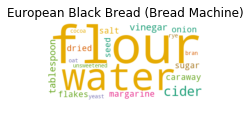

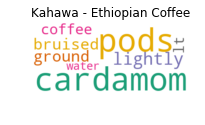

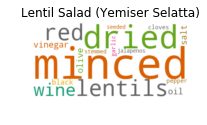

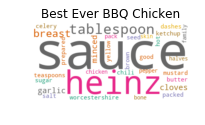

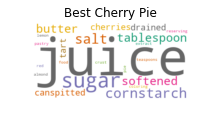

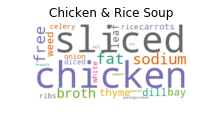

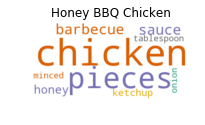

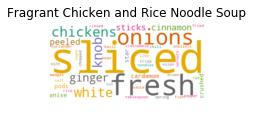

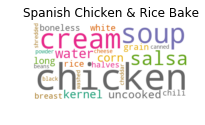

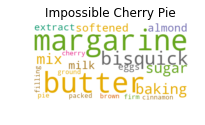

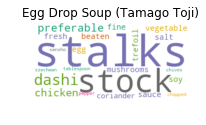

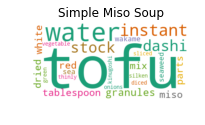

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
data_stp=data_stop.transpose()
for index,recipe_num in enumerate(data_stp.columns[:12]):
    wc.generate(recipe_df['Ingredients'][recipe_num])
    plt.figure(figsize=(10,10))
    plt.subplot(6,2,index+1)
    plt.imshow(wc,interpolation="bilinear")
    plt.axis('off')
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    plt.title(recipe_df.index[index])
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.25, top=0.9, wspace=0.6, hspace=0.3)
#plt.show()
#plt.tight_layout()
#plt.show()

In [27]:
# Sparse matrix generated by Tf-IDF vectorizer
vect_matrix

<20914x102183 sparse matrix of type '<class 'numpy.float64'>'
	with 931476 stored elements in Compressed Sparse Row format>

In [28]:
# Finding the shape of the sparse matrix
vect_matrix.shape

(20914, 102183)

In [29]:
# Compress the sparse matrix row-wise.
from scipy import sparse
vect_matrix = sparse.csr_matrix(vect_matrix)

In [30]:
def recommendations_func(recipe_name,dom):
    #constructing a pandas series from the dataframe df index
    indices=pd.Series(recipe_df.index)
    #initialize empty recommendations list
    recommendations = []
    
    #getting the index of the movie title passed into recommendations_func
    idx = indices[indices==recipe_name].index[0]
    #Int64Index([600], dtype='int64') so we extract the [0] element.
    print(idx)
    
    from sklearn.metrics.pairwise import cosine_similarity
    cosine_sim = cosine_similarity(dom[idx],dom)
    
    # creating a Series with the similarity scores in descending order
    cosine_sim = cosine_sim.flatten()
    score_series = pd.Series(cosine_sim).sort_values(ascending = False)
    print(score_series[:10])


    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    

    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommendations.append(recipe_df.index[i])
             
    return recommendations



In [31]:
recommended_recipes = recommendations_func('Best Ever BBQ Chicken',vect_matrix)

3
3        1.000000
13516    0.222867
1509     0.218141
15822    0.211890
6992     0.184122
6936     0.167601
13959    0.167337
12907    0.162058
15712    0.158170
6182     0.156425
dtype: float64


In [32]:
recommended_recipes 

['Bobbie-Q Sauce (Barbecue Sauce)',
 'Country Style Pork Ribs in a Crock Pot',
 'Roasted Bone-In Chicken Breasts With Herbs',
 'Savory Sweet Crock Pot Chicken',
 'Baked Balsamic Chicken',
 'Independence Day Chicken',
 'Very Simple Oven Fried Chicken -- Low Fat',
 'Sweet Hot Mustard Chicken Wings',
 'Ww Easy Barbecued Chicken',
 'Crock Pot Old South Pulled Pork on a Bun']

In [35]:
import logging
#data_df = data_stop.copy()
#data_df.index = recipe_df.index
data_dtm =data_stop.transpose()
def top_ingredient_recommendations(ingredient):
    #df = recipe_df.index
    pop_list=[]
    top_dict={}
    for c in data_dtm_transposed.columns:
        top = data_dtm_transposed[c].sort_values(ascending=False).head(10)
        top_dict[recipe_df.index[c]] = list(top.index)
    for key,value in top_dict.items():
        if ingredient in value:
            pop_list.append(key)
    return pop_list[:5]
            

In [38]:
top_ingredient_recommendations('chicken')

['Chicken & Rice Soup',
 'Honey BBQ Chicken',
 'Spanish Chicken & Rice Bake',
 'Simmering Hot and Sour Soup',
 'Creamy Cheesy Chicken & Rice']

In [86]:
type(recipe_df.index)

pandas.core.indexes.base.Index

In [64]:
import numpy as np
from scipy.sparse import csr_matrix

np.random.seed = 0
mat = csr_matrix(np.random.rand(10, 12)>0.7, dtype=int)
mat[1, 0] = 2 # add some variety to the matrix
mat[0, 1] = 3
print(mat.A)


[[1 3 0 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 1 0 0 1 1 0]
 [1 0 0 0 1 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 1 1 0 0]
 [0 0 1 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 1 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]]


C:\Users\shvpr\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [65]:
mat.data[:]

array([1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1], dtype=int32)

In [66]:
mat.indptr[:]

array([ 0,  2,  6, 10, 13, 16, 17, 20, 21, 25, 26], dtype=int32)

In [67]:
print(mat.data[mat.indptr[0]:mat.indptr[1]])

[1 3]


In [68]:
print(mat.data[mat.indptr[0]:mat.indptr[3]])

[1 3 2 1 1 1 1 1 1 1]


In [70]:
#print(mat.indices[:])
print(mat.indices[mat.indptr[1]:mat.indptr[2]])

[ 0  6  9 10]


In [75]:
mat.data[mat.indptr[1]:mat.indptr[2]].argsort()

array([1, 2, 3, 0], dtype=int64)

In [76]:
mat.indptr[:-1]

array([ 0,  2,  6, 10, 13, 16, 17, 20, 21, 25], dtype=int32)

In [77]:
mat.indptr[-1]

26